# Table of Contents
 <p><div class="lev1 toc-item"><a href="#School-District-Boundaries" data-toc-modified-id="School-District-Boundaries-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>School District Boundaries</a></div><div class="lev1 toc-item"><a href="#Counties" data-toc-modified-id="Counties-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Counties</a></div><div class="lev1 toc-item"><a href="#Attach-school-district-to-each-sale" data-toc-modified-id="Attach-school-district-to-each-sale-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Attach school district to each sale</a></div><div class="lev1 toc-item"><a href="#Borders" data-toc-modified-id="Borders-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Borders</a></div><div class="lev1 toc-item"><a href="#Data-Export" data-toc-modified-id="Data-Export-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Data Export</a></div>

In [1]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
# plt.rc("figure", autolayout=True)
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (12.0, 8.0)

In [2]:
EPSG=2263 # projection

In [3]:
import pandas as pd
import geopandas as gpd
plot_dataframe = gpd.plotting.plot_dataframe
import numpy as np
import itertools

In [4]:
import shapely
from shapely.geometry import Point, LineString, MultiLineString, MultiPoint

In [5]:
def readrolling(borough):
    dat = pd.read_csv("NYC_data/raw_data/rollingsales_%s.csv" % borough, 
        header=4, 
        thousands=",",
        dtype={" SALE PRICE ": np.float64, 
            "LAND SQUARE FEET": np.float64,
            "GROSS SQUARE FEET": np.float64,
            },
        parse_dates=["SALE DATE"],
        infer_datetime_format=True,
        skipinitialspace=True, 
        na_values=["-", "- ", "-   "],
        )
    dat.BOROUGH = borough.title()
    return dat
brooklyn=readrolling("brooklyn")
bronx=readrolling("bronx")
manhattan=readrolling("manhattan")
queens=readrolling("queens")

In [6]:
sales = pd.concat([brooklyn, bronx, manhattan, queens])
for catcol in ["BOROUGH", "BUILDING CLASS CATEGORY", "BUILDING CLASS AT TIME OF SALE", "ZIP CODE", "TAX CLASS AT PRESENT", "NEIGHBORHOOD"]:
    sales[catcol] = pd.Categorical(sales[catcol])
    try:
        sales[catcol].cat.categories = sales[catcol].cat.categories.str.strip()
    except AttributeError:
        pass
sales.ADDRESS=sales.ADDRESS.str.strip()
sales.reset_index(inplace=True, drop=True)
sales.ix[0]

BOROUGH                                           Brooklyn
NEIGHBORHOOD                                    BATH BEACH
BUILDING CLASS CATEGORY           01  ONE FAMILY DWELLINGS
TAX CLASS AT PRESENT                                     1
BLOCK                                                 6360
LOT                                                     13
EASE-MENT                                              NaN
BUILDING CLASS AT PRESENT                               A5
ADDRESS                                 8665 15TH   AVENUE
APARTMENT NUMBER                                       NaN
ZIP CODE                                             11228
RESIDENTIAL UNITS                                        1
COMMERCIAL UNITS                                       NaN
TOTAL UNITS                                              1
LAND SQUARE FEET                                      1547
GROSS SQUARE FEET                                     1428
YEAR BUILT                                            19

In [7]:
def readgeocoded(borough):
    dat = pd.read_csv("NYC_data/geocoded/rollingsales_%s_geocoded.csv" % borough)
    dat["BOROUGH"] = borough.title()
    dat.Address = dat.Address.str.strip()
    return dat

In [8]:
geocodes = pd.concat([readgeocoded(borough) for borough in ["brooklyn", "bronx", "manhattan", "queens"]])

In [9]:
sales_geocoded=pd.merge(sales, geocodes, how="left", left_on=["BOROUGH","ADDRESS"], right_on=["BOROUGH","Address"])
sales_geocoded.rename(columns={"SALE PRICE ": "SALE PRICE"}, inplace=True)
sales_geocoded.dropna(subset=["SALE PRICE"], inplace=True)
sales_geocoded.shape

(56815, 24)

In [10]:
sales_geocoded.iloc[0]

BOROUGH                                           Brooklyn
NEIGHBORHOOD                                    BATH BEACH
BUILDING CLASS CATEGORY           01  ONE FAMILY DWELLINGS
TAX CLASS AT PRESENT                                     1
BLOCK                                                 6361
LOT                                                     11
EASE-MENT                                              NaN
BUILDING CLASS AT PRESENT                               A5
ADDRESS                               71 BAY 10TH   STREET
APARTMENT NUMBER                                       NaN
ZIP CODE                                             11228
RESIDENTIAL UNITS                                        1
COMMERCIAL UNITS                                       NaN
TOTAL UNITS                                              1
LAND SQUARE FEET                                      2900
GROSS SQUARE FEET                                     1660
YEAR BUILT                                            19

In [11]:
sales_geometry = gpd.GeoSeries([Point(xy) for xy in zip(sales_geocoded.lng, sales_geocoded.lat)], crs={"proj":"latlong", "datum":"WGS84"})
sales_geometry=sales_geometry.to_crs(epsg=EPSG)

In [12]:
sales_geocoded["X_PRJ"]=[p.x for p in sales_geometry]
sales_geocoded["Y_PRJ"]=[p.y for p in sales_geometry]

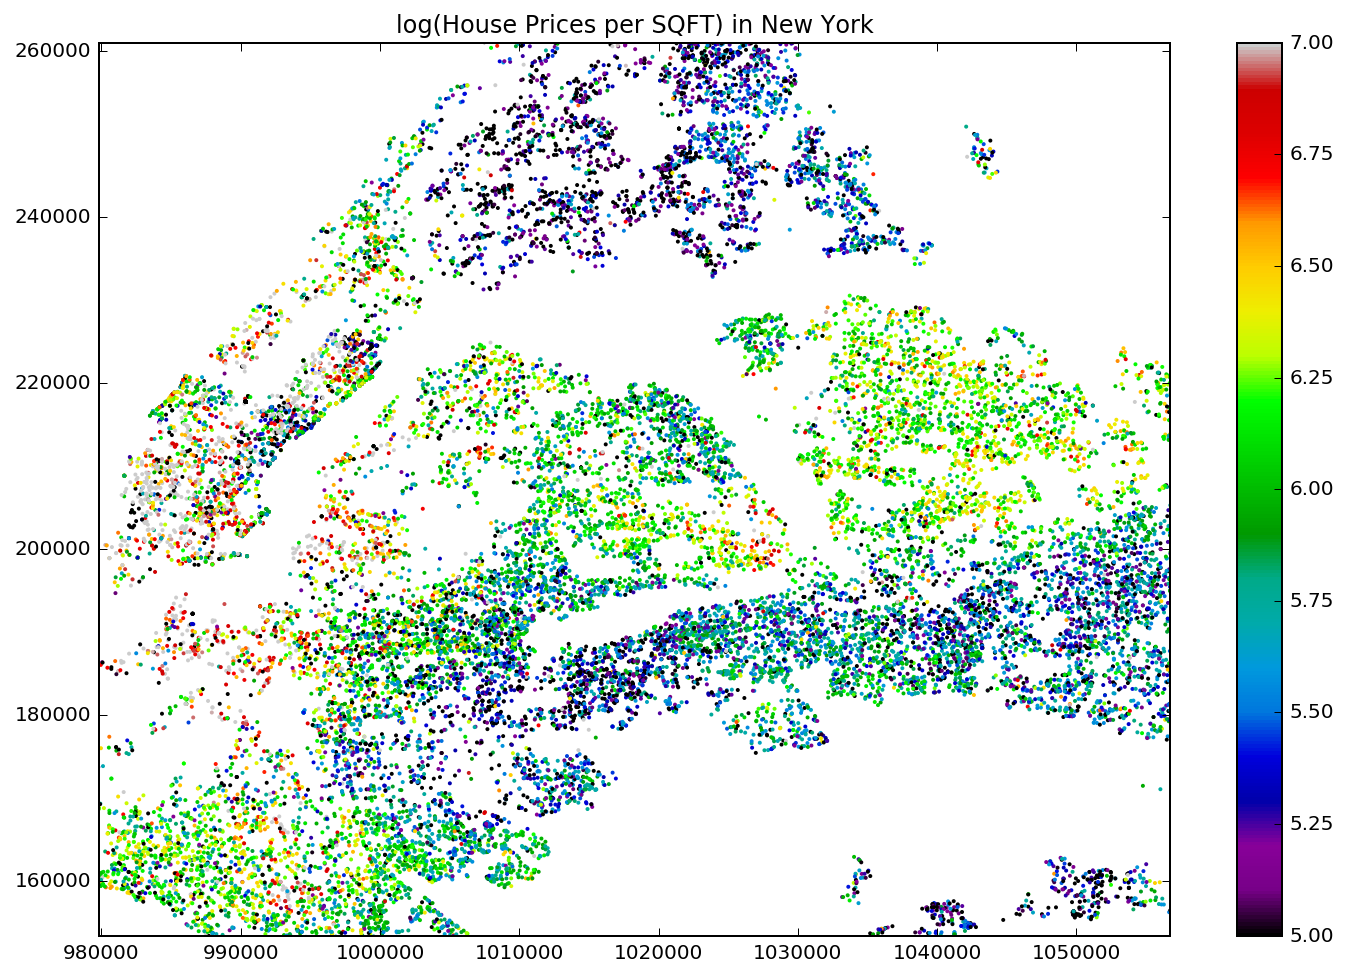

In [13]:
plt.scatter(sales_geocoded["X_PRJ"], sales_geocoded["Y_PRJ"], 
    c=np.log(sales_geocoded["SALE PRICE"])-np.log(sales_geocoded["GROSS SQUARE FEET"]),
    cmap="spectral",
    edgecolor="None",
    vmin=5.0,
    vmax=7.0,
    s=4,
    )
plt.xlim(np.percentile(sales_geocoded["X_PRJ"].dropna(), [2,98]))
plt.ylim(np.percentile(sales_geocoded["Y_PRJ"].dropna(), [2,98]))
plt.colorbar()
plt.title("log(House Prices per SQFT) in New York")

# School District Boundaries

In [14]:
nycdistrs=gpd.read_file("NYC_data/nysd_16c/nysd.shp").to_crs(epsg=EPSG)

In [15]:
nycdistrs.head()

,SchoolDist,Shape_Area,Shape_Leng,geometry
0,25,4.436314e+08,175816.081000,"POLYGON ((1033946.682983398 231157.9963988745,..."
1,20,2.427230e+08,95513.486010,"POLYGON ((977165.9473876945 176628.6171874552,..."
2,3,1.134879e+08,52071.976405,"POLYGON ((996235.5040283194 225859.7316283606,..."
3,4,5.262001e+07,52056.107857,(POLYGON ((1006028.597595215 231058.7958373566...
4,16,4.676362e+07,35848.904605,"POLYGON ((1002796.091003418 192779.0115966275,..."


''

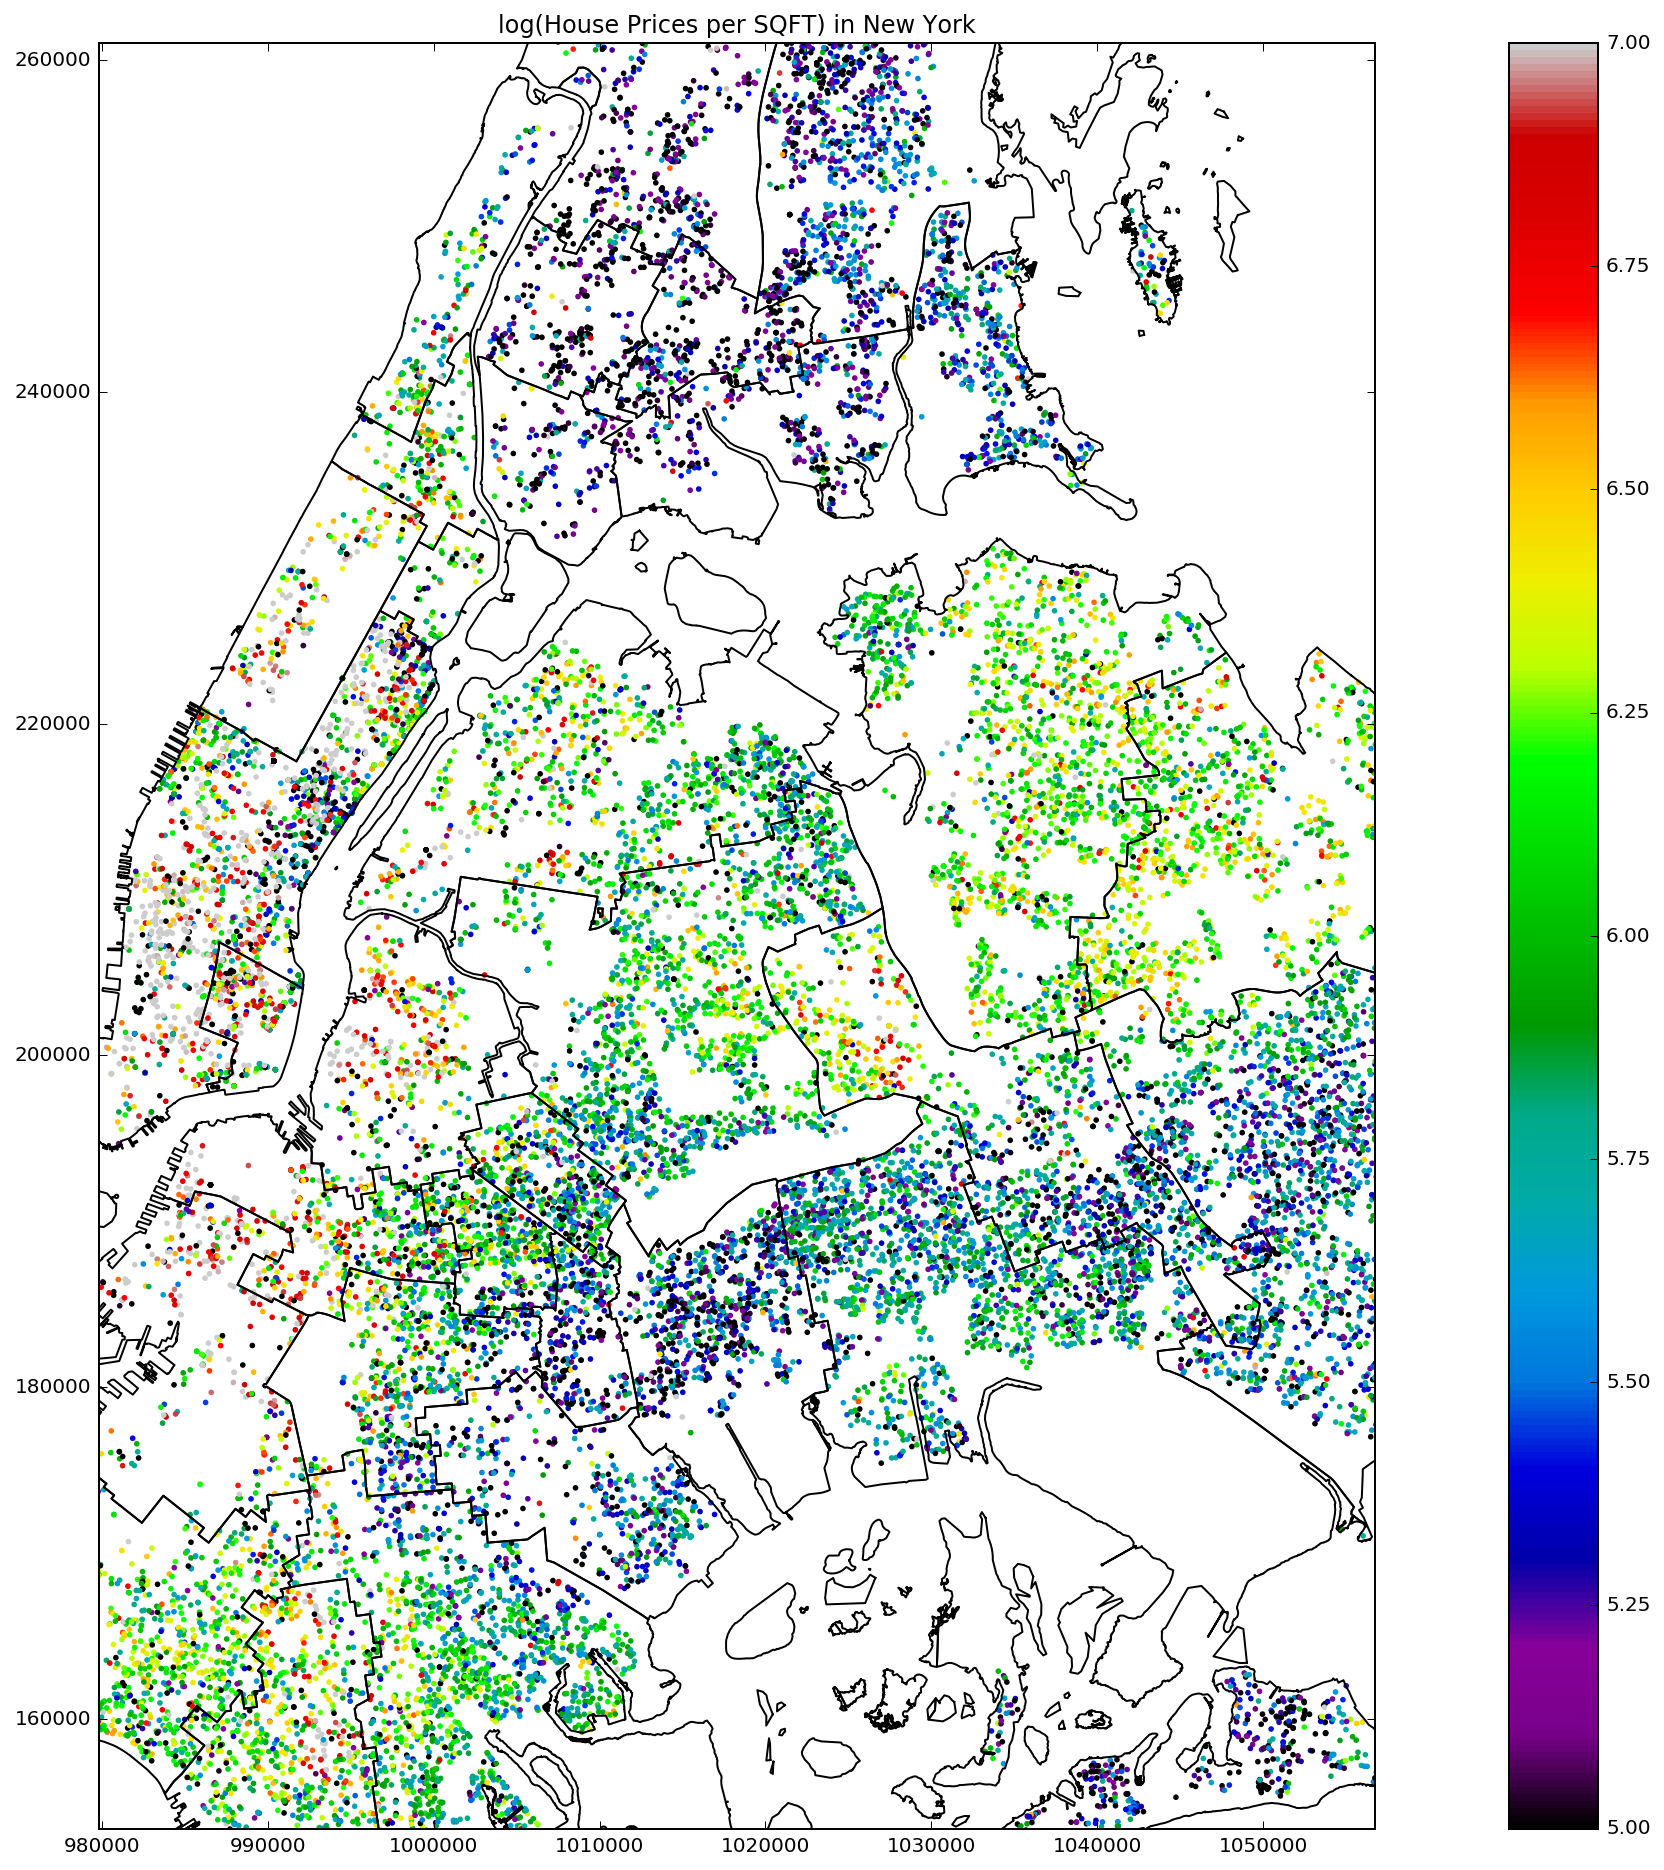

In [16]:
plot_dataframe(nycdistrs, color="None", figsize=(24.0, 16.0))
plt.scatter(sales_geocoded["X_PRJ"], sales_geocoded["Y_PRJ"], 
    c=np.log(sales_geocoded["SALE PRICE"])-np.log(sales_geocoded["GROSS SQUARE FEET"]),
    cmap="spectral",
    edgecolor="None",
    vmin=5.0,
    vmax=7.0,
    s=8,
    )
plt.xlim(np.percentile(sales_geocoded["X_PRJ"].dropna(), [2,98]))
plt.ylim(np.percentile(sales_geocoded["Y_PRJ"].dropna(), [2,98]))
plt.colorbar()
plt.title("log(House Prices per SQFT) in New York")
;

# Counties

In [17]:
counties=gpd.read_file("national_data/cb_2015_us_county_500k/cb_2015_us_county_500k.shp").to_crs(epsg=EPSG)

In [18]:
counties.head()

,AFFGEOID,ALAND,AWATER,COUNTYFP,COUNTYNS,GEOID,LSAD,NAME,STATEFP,geometry
0,0500000US01005,2.291821e+09,50864677.0,005,00161528,01005,06,Barbour,01,POLYGON ((-2707415.855703067 -2877716.26454153...
1,0500000US01023,2.365955e+09,19059247.0,023,00161537,01023,06,Choctaw,01,POLYGON ((-3540074.513784979 -2649887.10033756...
2,0500000US01035,2.201896e+09,6643480.0,035,00161543,01035,06,Conecuh,01,POLYGON ((-3251159.132570515 -2931142.43909308...
3,0500000US01051,1.601877e+09,99850740.0,051,00161551,01051,06,Elmore,01,POLYGON ((-2856337.972736434 -2436895.58067867...
4,0500000US01065,1.667805e+09,32525874.0,065,00161558,01065,06,Hale,01,POLYGON ((-3302901.948525312 -2364989.20114470...


# Attach school district to each sale

In [24]:
def get_ind(zones, point):
    ind=np.where(zones.contains(point))[0]
    if len(ind)==0:
        return None
    elif len(ind)>1:
        return None#np.argmin(zones.iloc[ind].area)
    return ind[0]

In [25]:
idistr=[get_ind(nycdistrs.geometry, house) for house in sales_geometry]

In [26]:
sum([i is None for i in idistr])

122

In [27]:
sales_geocoded["SchDistr"]=0
has_schdistr = np.array([i is not None for i in idistr])
sales_geocoded.ix[has_schdistr,"SchDistr"] = nycdistrs.SchoolDist.values[np.array(idistr)[has_schdistr].astype(int)]

# Borders

In [178]:
ndistr = nycdistrs.shape[0]
distr1_ls=[]
distr2_ls=[]
sentinels_ls=[]
borders_ls=[]

for i,j in itertools.combinations(range(ndistr),2):
    di = nycdistrs.geometry.values[i]
    dj = nycdistrs.geometry.values[j]
    distr_i = nycdistrs.SchoolDist.values[i]
    distr_j = nycdistrs.SchoolDist.values[j]
    border = di.boundary.intersection(dj.buffer(100))
#     if border.geom_type=='MultiPolygon':
#         lengths = [g.length for g in border.geoms]
#         border = border.geoms[np.argmax(lengths)]
    if not border.length:
        continue
#     assert isinstance(border, MultiLineString)
    if isinstance(border, MultiLineString):
        merged_border = shapely.ops.linemerge(border)
    else:
        merged_border = border
    sentinels = MultiPoint([merged_border.interpolate(x, normalized=True) for x in np.linspace(0,1.0,100)])
    sentinels_ls.append(sentinels)
    sentinels_ls.append(sentinels)
    borders_ls.append(merged_border)
    borders_ls.append(merged_border)
    distr1_ls.append(distr_i)
    distr1_ls.append(distr_j)
    distr2_ls.append(distr_j)
    distr2_ls.append(distr_i)

In [182]:
i=28
j=29
di = nycdistrs.geometry.values[i]
dj = nycdistrs.geometry.values[j]
distr_i = nycdistrs.SchoolDist.values[i]
distr_j = nycdistrs.SchoolDist.values[j]
border = di.boundary.intersection(dj.buffer(20))

In [183]:
type(border)

shapely.geometry.multilinestring.MultiLineString

In [184]:
merged_border=shapely.ops.linemerge(border)

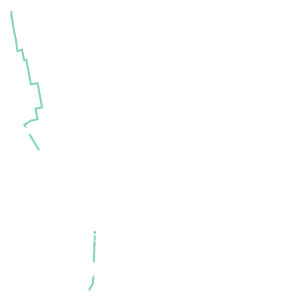

In [185]:
merged_border

In [186]:
merged_border[4].length

57.74401609714992

In [187]:
len(merged_border)

8

In [188]:
sentinels = MultiPoint([merged_border.interpolate(x, normalized=True) for x in np.linspace(0,1.0,100)])

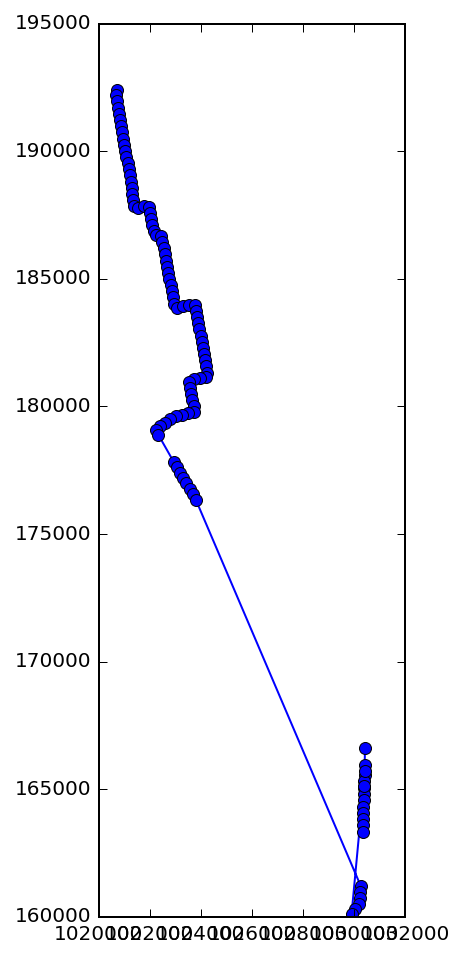

In [195]:
plt.plot([p.x for p in sentinels.geoms], [p.y for p in sentinels.geoms], "-o")
plt.gca().set_aspect("equal")

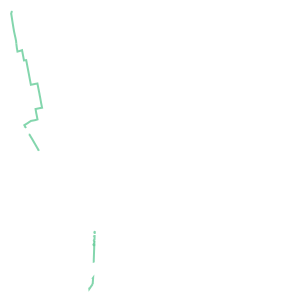

In [127]:
border

In [128]:
len(border.geoms)

10

In [179]:
borders = gpd.GeoDataFrame({"SchoolDistrict1":distr1_ls, "SchoolDistrict2": distr2_ls, "geometry": borders_ls})
sentinels = gpd.GeoDataFrame({"SchoolDistrict1":distr1_ls, "SchoolDistrict2": distr2_ls, "geometry": sentinels_ls})

# Data Export

In [70]:
sales_geocoded.to_csv("NYC_data/processed/NYC_sales.csv")

In [181]:
sentinels.to_file('NYC_data/processed/SchoolDistrict_borders/SchoolDistrict_sentinels.shp', driver='ESRI Shapefile')

In [72]:
with open("NYC_data/processed/SchoolDistrict_borders/SchoolDistrict_borders.json", "w") as f:
    f.write(borders.to_json())

In [180]:
with open("NYC_data/processed/SchoolDistrict_borders/SchoolDistrict_sentinels.json", "w") as f:
    f.write(sentinels.to_json())

In [34]:
import matplotlib.patheffects as path_effects

In [35]:
path_effects.Stroke?

In [36]:
?path_effects.SimpleLineShadow()

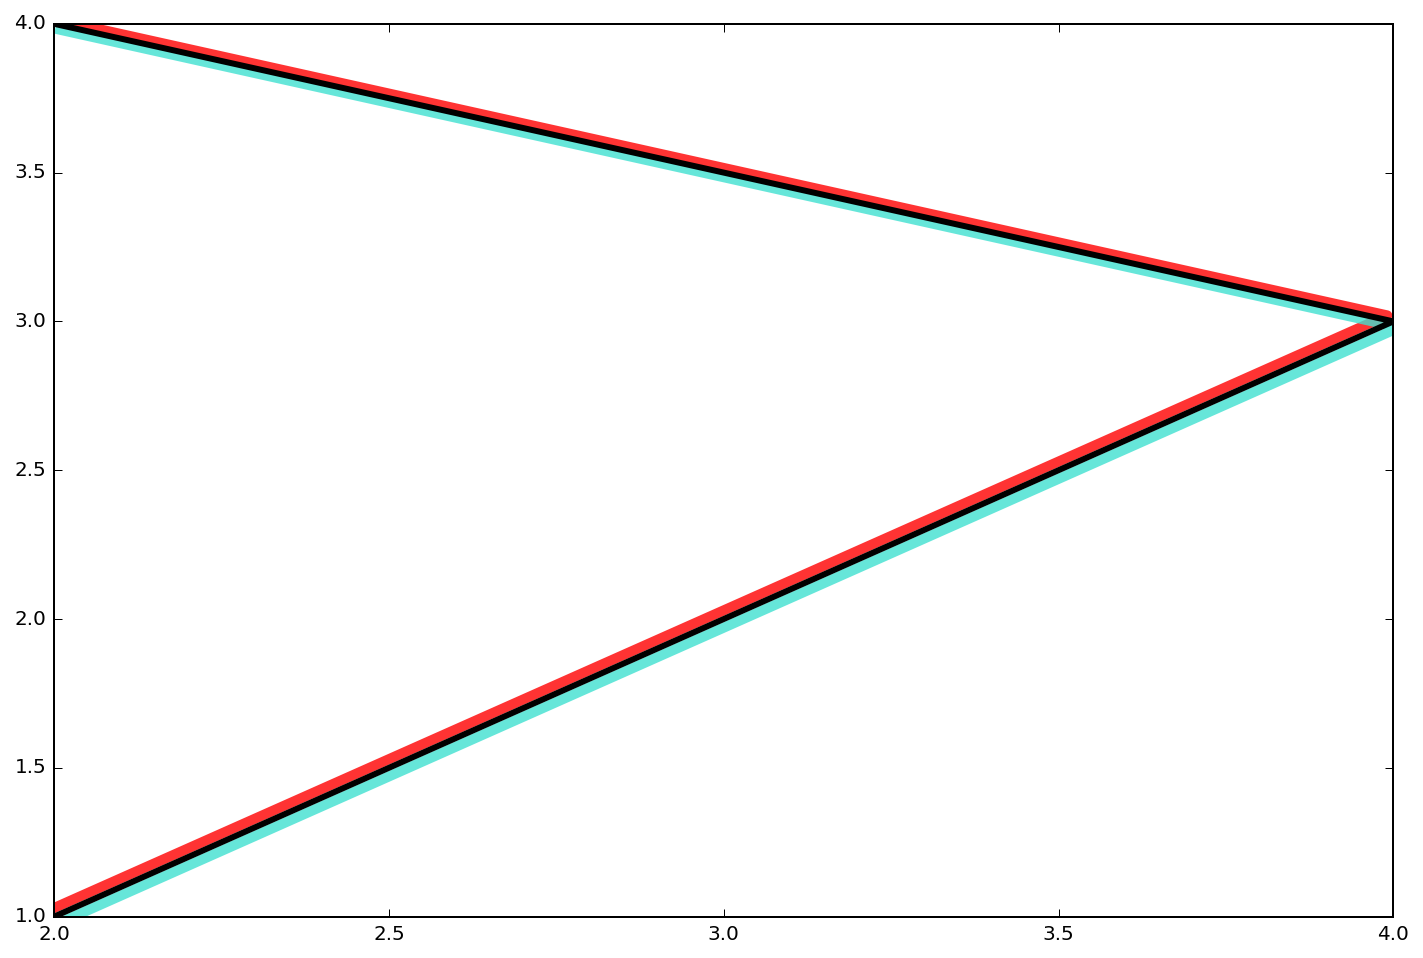

In [37]:
plt.plot([2,3,4,2], [1,2,3,4], linewidth=3, color="black", path_effects=[
    path_effects.SimpleLineShadow(shadow_color="red", linewidth=5, alpha=0.8, offset=(-3,3)),
    path_effects.SimpleLineShadow(shadow_color="turquoise", linewidth=5, alpha=0.8, offset=(3,-3)),
    path_effects.Normal()])